In [3]:
using Pkg
Pkg.activate(dirname(pwd()))
using ComputationalHeatTransfer
using Plots
gr()  
using XLSX
using JLD2
using SparseArrays

  Activating project at `~/Documents/GitHub/ComputationalHeatTransfer.jl`
┌ Info: Precompiling ComputationalHeatTransfer [5fc296c8-2eb5-40dc-a46d-98a68011a900]
└ @ Base loading.jl:1662
┌ Warning: Replacing docs for `SciMLBase.sol :: Union{Tuple, Tuple{D}, Tuple{S}, Tuple{N}, Tuple{T}} where {T, N, S, D}` in module `SciMLBase`
└ @ Base.Docs docs/Docs.jl:240
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1662


## Get fluid properties

In [4]:
fluid_type = "butane"
Tᵥ = 291.2

291.2

In [5]:
using UnPack

p_fluid = SaturationFluidProperty(fluid_type,Tᵥ)
@unpack Cpₗ,ρₗ,μₗ,hₗ,kₗ,Prₗ,Cpᵥ,ρᵥ,μᵥ,hᵥ,kᵥ,Prᵥ,σ,P,R,M,Rkg,αₗ,νₗ,νᵥ,hₗᵥ = p_fluid;

In [6]:
name_dict = [
    "ASETS-II OHP 1 SMALL HEATER_10W.jld2";
    "ASETS-II OHP 1 SMALL HEATER_20W.jld2";
    "ASETS-II OHP 1 SMALL HEATER_30W.jld2";
    "ASETS-II OHP 1 SMALL HEATER_40W.jld2";
    "ASETS-II OHP 1 LARGE HEATER_10W.jld2";
    "ASETS-II OHP 1 LARGE HEATER_20W.jld2";
    "ASETS-II OHP 1 LARGE HEATER_30W.jld2";
    "ASETS-II OHP 1 LARGE HEATER_40W.jld2";
    "ASETS-II OHP 2 SMALL HEATER_10W.jld2";
    "ASETS-II OHP 2 SMALL HEATER_20W.jld2";
    "ASETS-II OHP 2 SMALL HEATER_30W.jld2";
    "ASETS-II OHP 2 SMALL HEATER_40W.jld2";
    "ASETS-II OHP 2 LARGE HEATER_10W.jld2";
    "ASETS-II OHP 2 LARGE HEATER_20W.jld2";
    "ASETS-II OHP 2 LARGE HEATER_30W.jld2";
    "ASETS-II OHP 2 LARGE HEATER_40W.jld2";
];

name_exp_dict = [
    "20190607_F_PD_%23013_O001_H002_P010_expA.xlsx";
    "20190608_F_PD_%23014_O001_H002_P020_expA.xlsx";
    "20190614_F_PD_%23015_O001_H002_P030_expA.xlsx";
    "20190617_F_PD_%23016_O001_H002_P040_expA.xlsx";
    "20190604_F_PD_%23001_O001_H001_P010_expA.xlsx";
    "20190606_F_PD_%23002_O001_H001_P020_expA.xlsx";
    "20190612_F_PD_%23003_O001_H001_P030_expA.xlsx";
    "20190613_F_PD_%23004_O001_H001_P040_expA.xlsx";
    "20190607_F_PD_%23017_O002_H002_P010_expA.xlsx";
    "20190608_F_PD_%23018_O002_H002_P020_expA.xlsx";
    "20190614_F_PD_%23019_O002_H002_P030_expA.xlsx";
    "20190617_F_PD_%23020_O002_H002_P040_expA.xlsx";
    "20190604_F_PD_%23005_O002_H001_P010_expA.xlsx";
    "20190606_F_PD_%23006_O002_H001_P020_expA.xlsx";
    "20190612_F_PD_%23007_O002_H001_P030_expA.xlsx";
    "20190613_F_PD_%23008_O002_H001_P040_expA.xlsx";
];

In [7]:
# indexes=1:4
indexes=1:4 .+ 4
# indexes=1:4 .+ 8
# indexes=1:4 .+ 12

1:8

In [8]:
OHPt_nume = Vector{Float64}[]
OHPg_nume = Vector{Vector{Float64}}[]
power_nume = Float64[]
for namei in name_dict
#     numerical
    power = parse(Int64,namei[findfirst("HEATER", namei)[end] .+ [2,3]])
    OHPdata = load(dirname(dirname(dirname(pwd())))*"/OHPnume/"*namei);
    
    ohp = OHPdata["ohp"]
    boil_data = OHPdata["boil_data"]
    tube_hist_t = OHPdata["tube_hist_t"]
    tube_hist_θwall = OHPdata["tube_hist_θwall"]
    tube_hist_u = OHPdata["tube_hist_u"]
    integrator_tube = OHPdata["integrator_tube"]
    sysfinal = getsysfinal(tube_hist_u,tube_hist_θwall,integrator_tube);

    plate_T_hist = OHPdata["plate_T_hist"]

    integrator_plate = OHPdata["integrator_plate"]
    sys = integrator_plate.p
    
    
    x = [-2.75inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.75inch]
    y = [0.0,0.0,0.0,0.0,0.4inch,0.0,0.0,0.0];
    X =  VectorData(x,y);
    H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
    g = ScalarData(X);
    ghist = getghist(g,H,plate_T_hist);
    thist = tube_hist_t;
    
    push!(OHPt_nume,thist)
    push!(OHPg_nume,ghist)
    push!(power_nume,power)
end

In [9]:
RTDt_hist = Vector{Float64}[]
RTD_hist = Matrix{Float64}[]
for namei in name_exp_dict
# experimental
    xf = XLSX.readxlsx(dirname(dirname(dirname(pwd())))*"/OHPexp/"*namei)

    Onum, Hnum, power_exp = getconfig(namei)
    RTD,RTDt = getRTD(xf,Onum);
    
    push!(RTDt_hist,RTDt)
    push!(RTD_hist,RTD)
end

## get temperature curve time series

In [10]:
# x_map = 0:1e-3:L
# Hwall = zeros(size(x_map)[1],length(sysfinal))
# for i in eachindex(sysfinal)
#     Hwall[:,i] = sysfinal[i].mapping.H_interp_liquidtowall[x_map]
# end

# function liquidorvapor(Hwall_one,liquidthres=1000,dryvaporthres=100)
#     indicator = (Hwall_one > dryvaporthres && Hwall_one < liquidthres) ? 0 : 1
# end

In [11]:
# indicator = liquidorvapor.(Hwall');

In [12]:
# ohpξ = 0:L/length(ohp.x):(L-L/length(ohp.x));
# x_thres = 2.5inch - 0.5inch*0.9;
# condenser_indicator = (ohp.x .> x_thres);
# condenser_indicator_matrix = hcat(condenser_indicator, condenser_indicator)';

In [13]:
# heatmap(x_map,thist,indicator,xlabel="ξ [m]", ylabel="t [s]",title="0->liquid, 1->vapor",ylim=(0,100))
# # heatmap!(ohpξ,[thist[1];thist[end]],condenser_indicator_matrix,color=palette([:white, :blue], 2),opacity=0.5,colorbar=true,colorbar_title="condenser")

In [14]:
using Statistics

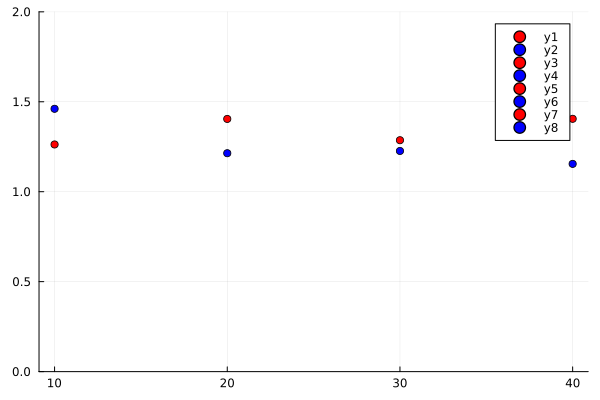

In [15]:
i1 = 8
i2 = 4
p1 = scatter()
for j in 1:4
    scatter!(p1, [power_nume[j]],[mean(power_nume[j] ./ (OHPg_nume[j][i2]-OHPg_nume[j][i1])[end-100:end])],color=:red)
    scatter!(p1, [power_nume[j]],[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[end-10:end])],color=:blue,ylim=(0,2))
end
p1

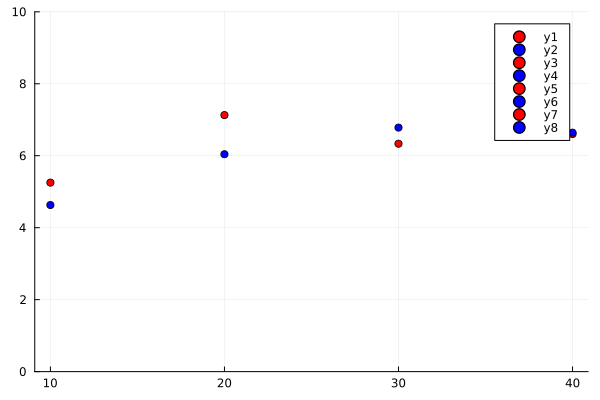

In [16]:
i1 = 8
i2 = 4
p2 = scatter()
for j in 5:8
    scatter!(p2, [power_nume[j]],[mean(power_nume[j] ./ (OHPg_nume[j][i2]-OHPg_nume[j][i1])[end-100:end])],color=:red)
    scatter!(p2, [power_nume[j]],[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[end-10:end])],color=:blue,ylim=(0,10))
end
p2

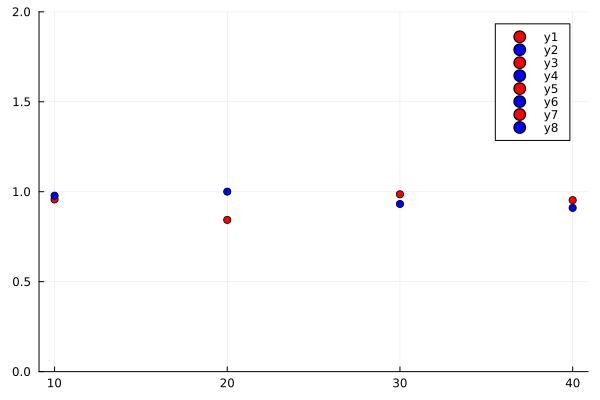

In [17]:
i1 = 8
i2 = 4
p3 = scatter()
for j in 9:12
    scatter!(p3, [power_nume[j]],[mean(power_nume[j] ./ (OHPg_nume[j][i2]-OHPg_nume[j][i1])[end-100:end])],color=:red)
    scatter!(p3, [power_nume[j]],[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[end-10:end])],color=:blue,ylim=(0,2))
end
p3

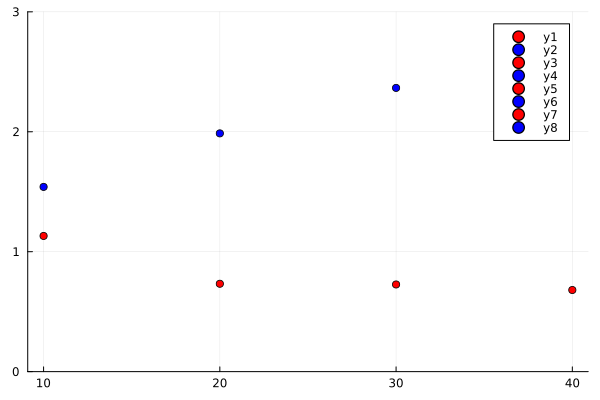

In [18]:
i1 = 8
i2 = 4
p4 = scatter()
for j in 13:16
    scatter!(p4, [power_nume[j]],[mean(power_nume[j] ./ (OHPg_nume[j][i2]-OHPg_nume[j][i1])[end-100:end])],color=:red)
    scatter!(p4, [power_nume[j]],[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[end-10:end])],color=:blue,ylim=(0,3))
end
p4

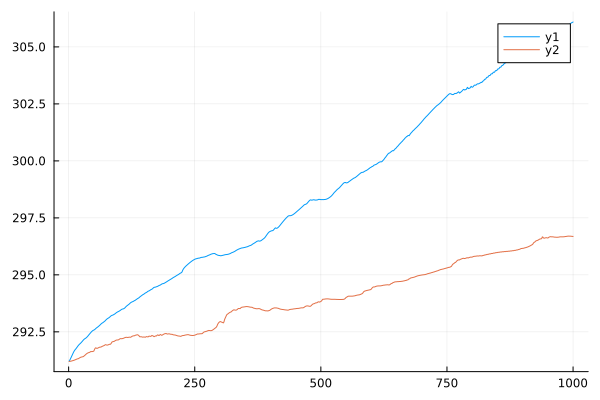

In [21]:
plot(OHPg_nume[13][i2])
plot!(OHPg_nume[13][i1])

In [189]:
Hₗ = 462
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
    plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :green]),line_z=Htmp_marker,xlabel="x ",ylabel="y ",title=string("time = ", round(tube_hist_t[i], digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

LoadError: UndefVarError: sysfinal not defined